In [10]:
import numpy as np
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

#
# 活性化関数 activator
#

# 全結合層 (Fully Connected Layer, Affine層, Dense層)
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2) # 行列 shape(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)           # ベクトル shape(1, n_nodes2)
        self.Z = None
        self.hW = 0
        self.hB = 0

    def forward(self, X):
        self.Z = X  # backwardで使う
        return X @ self.W + self.B

    def backward(self, d_a):
        self.dB = np.sum(d_a, axis=0) # なぜsumになるんだ
        self.dW = self.Z.T @ d_a      # おそらく微分値がこうなるんだと思う
        self.dZ = d_a @ self.W.T      # おそらく微分値がこうなるんだと思う
        self.optimizer.update(self)   # 自身のW/Bをoptimizerにより更新
        return self.dZ

class Sigmoid:
    def forward(self, A):
        self.A = A
        return 1 / (1 + np.exp(-A))

    def backward(self, dZ):
        A = self.A
        c = 1 / (1 + np.exp(-A))
        d = (1 / (1 + np.exp(-A)))**2
        return dZ * (c - d)

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)

    def backward(self, dZ):
        return dZ * (1 - np.tanh(self.A)**2)

class Softmax:
    def forward(self, A):
        exp_a = np.exp(A) # eのx乗を返す
        sum_exp_a = np.sum(np.exp(A), axis=1).reshape(-1, 1) # 指数関数の和
        return exp_a / sum_exp_a

    def backward(self, z, y):
        # ゼロつく本だとbatch_sizeで割っているが、悪と逆に悪くなる。理由はまだ不明
        d_a = z - y # 実質これが勾配
        loss = -( np.sum(y * np.log(z)) / len(y) )
        return d_a, loss

class ReLU:
    def forward(self, A):
        self.A = A
        return np.maximum(0, A) # 0とxを比較して大きい方の数値を返す

    def backward(self, dZ):
        return dZ * np.where(self.A > 0, 1, 0)

# 更新アルゴリズム optimizer
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB

class AdaGrad:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.hW += layer.dW * layer.dW # layer側に代入している理由: AdaGradはほかのFCオブジェクトで使い回されるため、FC側に保持する必要がある
        layer.hB += layer.dB * layer.dB
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.hW) + 1e-7)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.hB) + 1e-7) # Note. / len(layer.Z)

# 初期値 initializer
class SimpleInitializer:
    def __init__(self, sigma, n_nodes1, n_nodes2):
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2

    def W(self):
        # display("self.sigma: ", self.sigma)
        # display("self.n_nodes1: ", self.n_nodes1)
        # display("self.n_nodes2: ", self.n_nodes2)
        return self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)

    def B(self):
        return self.sigma * np.random.randn(1, self.n_nodes2)

class XavierInitializer:
    # sigmaはinterfaceを合わせるためだけに実装
    def __init__(self, sigma):
        self.s = None

    def W(self, n_nodes1, n_nodes2):
        self.s = np.sqrt(1 / n_nodes1)
        return self.s * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.s * np.random.randn(1, n_nodes2)

class HeInitializer:
    # sigmaはinterfaceを合わせるためだけに実装
    def __init__(self, sigma):
        self.s = None

    def W(self, n_nodes1, n_nodes2):
        # display("n_nodes1: ", n_nodes1)
        # display("n_nodes2: ", n_nodes2)

        self.s = np.sqrt(2 / n_nodes1)
        # display("self.s: ", self.s)
        w = self.s * np.random.randn(n_nodes1, n_nodes2)
        # display("w: ", w)
        return w

    def B(self, n_nodes2):
        return self.s * np.random.randn(1, n_nodes2)

# ミニバッチ
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# スクラッチクラス
class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, epoch=1, lr=0.5, optimizer=SGD, initializer=HeInitializer, activator=ReLU):
        (self.n_features, self.n_nodes1, self.n_nodes2, self.n_output) = (784, 400, 200, 10)
        self.sigma = 0.02
        self.batch_size = 20
        self.lr = lr
        self.epoch = epoch
        self.optimizer = optimizer
        self.initializer = initializer
        self.activator = activator
        (self.loss_train, self.loss_valid) = (None, None)
        (self.FC1, self.FC2, self.FC3) = (None, None, None)
        (self.activation1, self.activation2, self.activation3) = (None, None, None)

    def fit(self, X, y, X_valid, y_valid):
        self.loss_train = []
        self.loss_valid = []
        optimizer = self.optimizer(self.lr)

        # 各レイヤーの初期化
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activator()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activator()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for x_mini, y_mini in mini_batch:
                z3 = self._forward(x_mini)
                self._backward(z3, y_mini)
            # loss_train
            z3 = self._forward(X)
            _, loss = self.activation3.backward(z3, y)
            self.loss_train.append(loss)
            # loss_valid
            z3 = self._forward(X_valid)
            _, loss = self.activation3.backward(z3, y_valid)
            self.loss_valid.append(loss)

    def predict(self, x):
        z3 = self._forward(x)
        return np.argmax(z3, axis=1)

    def _forward(self, x):
        # layer 1
        a1 = self.FC1.forward(x)            # 仮定関数の役目 a=affine
        z1 = self.activation1.forward(a1)   # アルゴリズムによる変換(標準化みたいなもの)
        # layer 2
        a2 = self.FC2.forward(z1)
        z2 = self.activation2.forward(a2)
        # layer final
        a3 = self.FC3.forward(z2)
        z3 = self.activation3.forward(a3)
        return z3   # shape(処理中の行数, 最終層のノード数)

    def _backward(self, z3, y):
        # layer final
        d_a3, _ = self.activation3.backward(z3, y) # d=delta
        d_z2 = self.FC3.backward(d_a3)
        # layer 2
        d_a2 = self.activation2.backward(d_z2)
        d_z1 = self.FC2.backward(d_a2)
        # layer 1
        d_a1 = self.activation1.backward(d_z1)
        _ = self.FC1.backward(d_a1) # 理想の特徴量の状態(これは保存しない？)

<class '__main__.FC'>


In [58]:
#
# 前処理
#

# データセット
(x_train, y_train), (x_test, y_test) = mnist.load_data() # shape(60000, 28, 28)

# 平滑化
x_train = x_train.reshape(-1, 784) # shape(60000, 784)
x_test = x_test.reshape(-1, 784)   # shape(60000, 784)
# スケール調整
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

def result(model, x_train, y_train, x_test, y_test):
    # 学習結果
    display(model.loss_train)

    # 予測
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    # 評価
    print("train accuracy_score: \t", accuracy_score(y_train, pred_train))
    print("train precision_score: \t", precision_score(y_train, pred_train, average="micro"))
    print("train recall_score: \t", recall_score(y_train, pred_train, average="micro"))
    print("train f1_score: \t", f1_score(y_train, pred_train, average="micro"))
    print("train accuracy_score: \t", accuracy_score(y_test, pred_test))
    print("train precision_score: \t", precision_score(y_test, pred_test, average="micro"))
    print("train recall_score: \t", recall_score(y_test, pred_test, average="micro"))
    print("train f1_score: \t", f1_score(y_test, pred_test, average="micro"))

    # lossグラフ
    plot_x = [i for i in range(1, model.epoch+1)]
    plt.plot(plot_x, model.loss_train, label='train')
    plt.plot(plot_x, model.loss_valid, label='valid')
    plt.legend()
    plt.show()

# x_train = x_train[:20]
# x_test = x_test[:20]
# y_train_one_hot = y_train_one_hot[:20]
# y_test_one_hot = y_test_one_hot[:20]

In [69]:
# 学習 AdaGrad, Xavier, Tanh
import time
start = time.time()

model = ScratchDeepNeuralNetworkClassifier(epoch=30, lr=0.01, optimizer=AdaGrad, initializer=XavierInitializer, activator=Tanh)
model.fit(x_train, y_train_one_hot, x_test, y_test_one_hot)

print ("elapsed_time: {} ".format(int(time.time() - start)) + "[sec]")

elapsed_time: 399 [sec]


x_train: 60000 x_test: 10000


[0.0969711926538501,
 0.06503729865896916,
 0.04432030790529356,
 0.02888564598816412,
 0.02196190337067925,
 0.01646644789854705,
 0.012304613216466751]

train accuracy_score: 	 0.99845
train precision_score: 	 0.99845
train recall_score: 	 0.99845
train f1_score: 	 0.99845
train accuracy_score: 	 0.9818
train precision_score: 	 0.9818
train recall_score: 	 0.9818
train f1_score: 	 0.9818


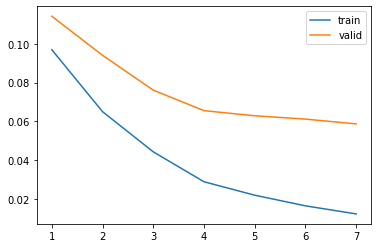

In [48]:
print(f"x_train: {len(x_train)} x_test: {len(x_test)}")
result(model, x_train, y_train, x_test, y_test)


x_train: 60000 x_test: 10000


[0.09406527513840535,
 0.062479981295288214,
 0.04394016115383058,
 0.027848893185862422,
 0.022325743289208128,
 0.017195751900641168,
 0.012165682378441511]

train accuracy_score: 	 0.99825
train precision_score: 	 0.99825
train recall_score: 	 0.99825
train f1_score: 	 0.99825
train accuracy_score: 	 0.9805
train precision_score: 	 0.9805
train recall_score: 	 0.9805
train f1_score: 	 0.9805


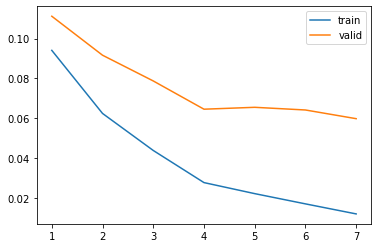

In [51]:
# softmax の backward修正パターン softmaxでlen割を入れる

print(f"x_train: {len(x_train)} x_test: {len(x_test)}")
result(model, x_train, y_train, x_test, y_test)


x_train: 60000 x_test: 10000


[0.13919333094787806,
 0.103228867458226,
 0.08651057062830451,
 0.06971588111929636,
 0.062254436524321874,
 0.05431966358009002,
 0.04722558450269976,
 0.04314896272187759,
 0.038615034816247375,
 0.03627482016132114,
 0.031614267466225345,
 0.0290288336511677,
 0.026457317711278815,
 0.024617294977629947,
 0.023053779977415877,
 0.021715562743035183,
 0.018958978707876446,
 0.017668361058587816,
 0.01645949436145144,
 0.01558857431190933,
 0.014356401173820707,
 0.013701579343910275,
 0.012714794309632975,
 0.012001621034121867,
 0.011558900994323938,
 0.010544997824584014,
 0.010159981220721835,
 0.009229899125839531,
 0.008937085956785587,
 0.008392062427872934]

train accuracy_score: 	 0.9994
train precision_score: 	 0.9994
train recall_score: 	 0.9994
train f1_score: 	 0.9994
train accuracy_score: 	 0.9811
train precision_score: 	 0.9811
train recall_score: 	 0.9811
train f1_score: 	 0.9811


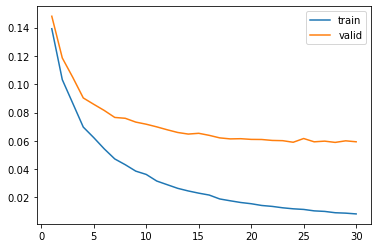

In [70]:
# softmax の backward修正パターン

print(f"x_train: {len(x_train)} x_test: {len(x_test)}")
result(model, x_train, y_train, x_test, y_test)

In [11]:
print(FC)



<class '__main__.FC'>
